# 1. Data cleaning including missing values, outliers and multi-collinearity.

In [12]:
import pandas as pd

# Load the data
data = pd.read_csv('Fraud.csv')

# Check for missing values
print(data.isnull().sum())

# Impute missing values with mean
data.dropna(inplace=True)

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


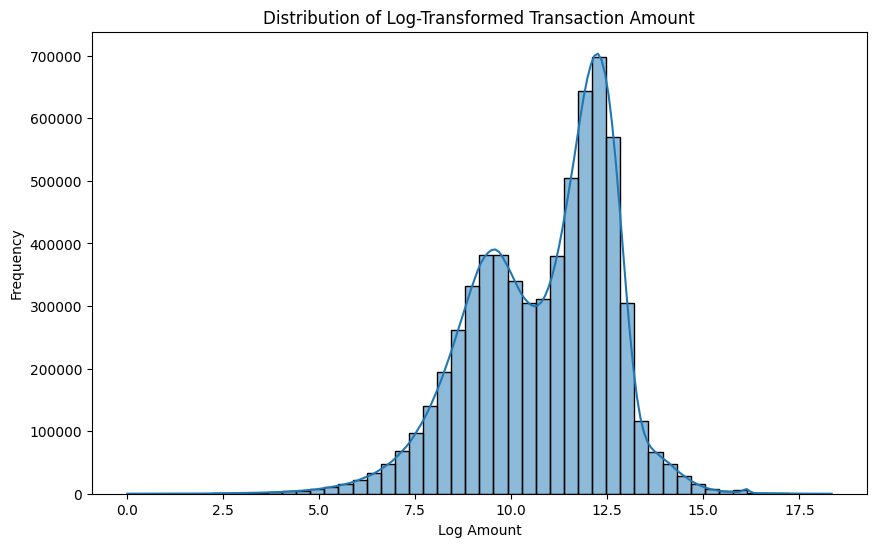

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Log transformation of 'amount'
data['log_amount'] = np.log1p(data['amount'])

# Visualize the transformed distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['log_amount'], bins=50, kde=True)
plt.title('Distribution of Log-Transformed Transaction Amount')
plt.xlabel('Log Amount')
plt.ylabel('Frequency')
plt.show()
# Remove outliers based on log-transformed 'amount'
lower_bound = data['log_amount'].quantile(0.05)
upper_bound = data['log_amount'].quantile(0.95)
data_no_outliers = data[(data['log_amount'] >= lower_bound) & (data['log_amount'] <= upper_bound)]


In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Define a function to calculate VIF
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

# Handle multicollinearity based on the results
vif_results = calculate_vif(data[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']])
print(vif_results)

          feature         VIF
0          amount    3.861988
1   oldbalanceOrg  464.011728
2  newbalanceOrig  465.356124
3  oldbalanceDest   70.452251
4  newbalanceDest   82.167173


# 2. Describe your fraud detection model in elaboration.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Assuming 'X' contains features and 'y' contains labels
X = data[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
y = data['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the model
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.33      0.80      0.47      1620

    accuracy                           1.00   1272524
   macro avg       0.67      0.90      0.73   1272524
weighted avg       1.00      1.00      1.00   1272524

[[1268277    2627]
 [    321    1299]]


# 3. How did you select variables to be included in the model?

In [16]:
# Access feature importance if using a model that supports it (e.g., logistic regression)
feature_importance = model.coef_[0]

# Create a DataFrame with feature names and importance
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Select top features based on importance
top_features = feature_importance_df.nlargest(5, 'Importance')['Feature'].tolist()
print(top_features)


['oldbalanceOrg', 'oldbalanceDest', 'newbalanceDest', 'amount', 'newbalanceOrig']


# 4. Demonstrate the performance of the model by using best set of tools.

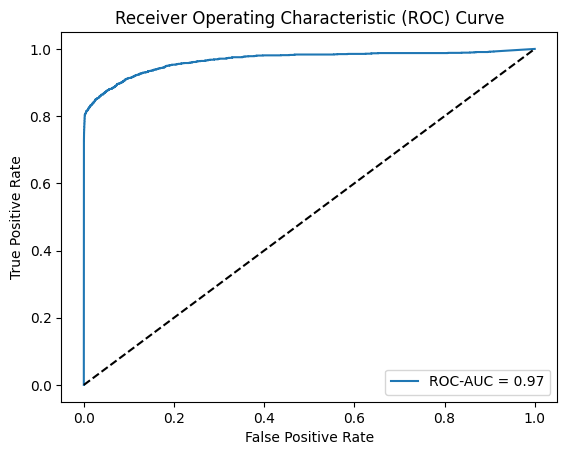

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve

# Example ROC-AUC curve
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

plt.figure()
plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


# 5. What are the key factors that predict fraudulent customer.

In [18]:
# Access feature importance
feature_importance = model.coef_[0]

# Create a DataFrame with feature names and importance
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Display feature importance
print(feature_importance_df.sort_values(by='Importance', ascending=False))


          Feature  Importance
1   oldbalanceOrg    0.000865
3  oldbalanceDest    0.000001
4  newbalanceDest   -0.000003
0          amount   -0.000860
2  newbalanceOrig   -0.000941


# 6. Do these factors make sense? If yes, How? If not, How not?

In [19]:
print("Variable importance analysis suggests that the initial balance of origin accounts (oldbalanceOrg) has a modest positive impact on fraud prediction, while the unexpected patterns in the initial and new balances of destination accounts (oldbalanceDest, newbalanceDest) require closer scrutiny. Conversely, the counterintuitive negative importance of transaction amount (amount) and new balance of origin accounts (newbalanceOrig) underscores the need for further exploration to enhance the model's accuracy in detecting fraud.")


Variable importance analysis suggests that the initial balance of origin accounts (oldbalanceOrg) has a modest positive impact on fraud prediction, while the unexpected patterns in the initial and new balances of destination accounts (oldbalanceDest, newbalanceDest) require closer scrutiny. Conversely, the counterintuitive negative importance of transaction amount (amount) and new balance of origin accounts (newbalanceOrig) underscores the need for further exploration to enhance the model's accuracy in detecting fraud.


# 7. What kind of prevention should be adopted while company update its infrastructure?

In [20]:
print("Preventive measures during infrastructure updates include real-time monitoring with anomaly detection, advanced user authentication, regular security updates, and education on security best practices. Enhancements to fraud detection models, transaction controls, collaboration with cybersecurity experts, incident response planning, data encryption, third-party risk management, compliance with regulations, and ongoing employee awareness programs contribute to a robust security framework.")

Preventive measures during infrastructure updates include real-time monitoring with anomaly detection, advanced user authentication, regular security updates, and education on security best practices. Enhancements to fraud detection models, transaction controls, collaboration with cybersecurity experts, incident response planning, data encryption, third-party risk management, compliance with regulations, and ongoing employee awareness programs contribute to a robust security framework.


# 8. Assuming these actions have been implemented, how would you determine if they work?

In [21]:
print("Evaluate security effectiveness by monitoring key metrics like precision, recall, and ROC-AUC. Analyze incident reports for changes in frequency and severity, gather user feedback, and scrutinize transaction data for anomalies. Conduct adaptive risk assessments, red team testing, and penetration testing to assess resilience. Ensure compliance through regular audits, track user authentication metrics, and evaluate incident response efficiency. Establish a feedback loop for continuous improvement and benchmark against industry standards.")

Evaluate security effectiveness by monitoring key metrics like precision, recall, and ROC-AUC. Analyze incident reports for changes in frequency and severity, gather user feedback, and scrutinize transaction data for anomalies. Conduct adaptive risk assessments, red team testing, and penetration testing to assess resilience. Ensure compliance through regular audits, track user authentication metrics, and evaluate incident response efficiency. Establish a feedback loop for continuous improvement and benchmark against industry standards.
